# Fama and French Factor Model #

### The Model Specification ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_financial_data
from functions import import_stock_universe
from capm_toolkit import wexp
from capm_toolkit import compute_daily_returns
from capm_toolkit import compute_excess_returns
from capm_toolkit import capm_regression

In [2]:
# Get Data from Stock

ticker = 'MSFT'

stock_price = import_financial_data(ticker)
stock_returns = stock_price['adj_close'].pct_change(1).dropna()

stock_returns

Date
2015-01-05   -0.009303
2015-01-06   -0.014571
2015-01-07    0.012705
2015-01-08    0.029418
2015-01-09   -0.008405
                ...   
2024-10-22    0.020846
2024-10-23   -0.006807
2024-10-24    0.000306
2024-10-25    0.008052
2024-10-28   -0.003644
Name: adj_close, Length: 2471, dtype: float64

In [3]:
# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500
sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the SMB Premium
SMB = pd.read_csv(r"..\additional_data\famafrench_smb.csv")
SMB = SMB.set_index('Date')
SMB.index = pd.to_datetime(SMB.index)

# Get the data for the HML Premium
HML = pd.read_csv(r"..\additional_data\famafrench_hml.csv")
HML = HML.set_index('Date')
HML.index = pd.to_datetime(HML.index)

In [4]:
# Create the data
daily_rfr = compute_daily_returns(rfr['risk_free_rate'])
market_excess_returns = compute_excess_returns(sp500['sp_500'], rfr['risk_free_rate'])
stock_excess_returns = stock_returns - daily_rfr

In [6]:
# Create the regression dataframe
regression_df = pd.DataFrame(index = stock_excess_returns.index)

regression_df['stock'] = stock_excess_returns
regression_df['MKT'] = market_excess_returns
regression_df['SMB'] = SMB
regression_df['HML'] = HML
regression_df.dropna(inplace = True)

regression_df

,stock,MKT,SMB,HML
Date,,,,
2015-01-05,-0.009359,-0.018334,0.000614,-0.007472
2015-01-06,-0.014625,-0.008948,-0.002716,-0.000653
2015-01-07,0.012651,0.011576,0.000453,-0.003583
2015-01-08,0.029362,0.017832,0.002447,-0.002477
2015-01-09,-0.008460,-0.008458,0.001843,-0.001128
...,...,...,...,...
2024-10-22,0.020732,-0.000589,-0.005932,0.004081
2024-10-23,-0.006922,-0.009307,0.000967,0.005278
2024-10-24,0.000192,0.002031,0.003483,-0.006245


In [7]:
# Create the Y Vector
y = regression_df['stock']

# Create the X Matrix
x = regression_df[['MKT', 'SMB', 'HML']]

In [8]:
x.corr()

,MKT,SMB,HML
MKT,1.000000,0.242885,0.054839
SMB,0.242885,1.000000,0.329923
HML,0.054839,0.329923,1.000000


In [9]:
# Calculate Weights
window = len(y)

# The results of the model
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())  

                            WLS Regression Results                            
Dep. Variable:                  stock   R-squared:                       0.723
Model:                            WLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     2130.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:19:56   Log-Likelihood:                 7962.4
No. Observations:                2454   AIC:                        -1.592e+04
Df Residuals:                    2450   BIC:                        -1.589e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.451e-05      0.000     -0.188      0.8

In [10]:
# Let us Create a new function
def FamaFrenchFactors(
    stock_returns: pd.Series, 
    market_returns: pd.Series, 
    small_minus_big_series: pd.Series,
    high_minus_low_series: pd.Series,
):

    # Align time series to the same date range
    common_index = stock_returns.index.intersection(market_returns.index) \
    .intersection(small_minus_big_series.index) \
    .intersection(high_minus_low_series.index)
    
    stock_returns = stock_returns.loc[common_index]
    market_returns = market_returns.loc[common_index]
    small_minus_big_series = small_minus_big_series.loc[common_index]
    high_minus_low_series = high_minus_low_series.loc[common_index]
    
    X = pd.concat([market_returns, small_minus_big_series, high_minus_low_series], axis=1)
    y = stock_returns

    # Create weights with exponential decay
    T = len(y)
    weights = T * wexp(T, T/2)
    
    # Fit WLS regression
    model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()

    # Avoid KeyError by checking if params exist
    params = model.params
    
    alpha = params.iloc[0]
    capm_beta = params.iloc[1]
    smb_beta = params.iloc[2]
    hml_beta = params.iloc[3]
            
    parameters = {
        'alpha':alpha,
        'capm_beta':capm_beta,
        'smb_beta':smb_beta,
        'hml_beta':hml_beta,
    }
    
    return parameters

In [11]:
# Check if the Function Works

parameters = FamaFrenchFactors(
    stock_excess_returns,
    market_excess_returns,
    SMB,
    HML,
)

parameters

{'alpha': -3.450960231743508e-05,
 'capm_beta': 1.2511018266618037,
 'smb_beta': -0.46214538350169354,
 'hml_beta': -0.5648331763206494}

### Obtaining the Coefficients for all the Stocks ###

In [12]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = import_stock_universe(
    folder_path,
    ['Adjusted_close', 'Company Market Cap', 'Price_to_Book_inverse'],
    ['adj_close', 'mkt_cap', 'btp'],
)

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [14]:
# Calculate the Coefficients
tickers = []
betas_capm = []
betas_smb = []
betas_hml = []

# Create the Loop
for ticker in dataframes.keys():
    stock_returns = dataframes[ticker]['adj_close'].pct_change(1).dropna()
    stock_excess_returns = stock_returns - daily_rfr

    # Calculations
    parameters = FamaFrenchFactors(
        stock_excess_returns,
        market_excess_returns,
        SMB,
        HML,
    )

    tickers.append(ticker)
    betas_capm.append(parameters['mkt_beta'])
    betas_smb.append(parameters['smb_beta'])
    betas_hml.append(parameters['hml_beta'])

    print(f'{ticker} is ready.')

A is ready.
AAPL is ready.
ABBV is ready.
ABT is ready.
ADBE is ready.
ADI is ready.
ADM is ready.
ADP is ready.
ADSK is ready.
AEE is ready.
AEP is ready.
AES is ready.
AFL is ready.
AIG is ready.
AIZ is ready.
AJG is ready.
AKAM is ready.
ALB is ready.
ALGN is ready.
ALL is ready.
AMAT is ready.
AMD is ready.
AME is ready.
AMGN is ready.
AMP is ready.
AMT is ready.
AMZN is ready.
ANET is ready.
ANSS is ready.
AOS is ready.
APA is ready.
APD is ready.
APH is ready.
APO is ready.
ARE is ready.
AWK is ready.
BALL is ready.
BDX is ready.
BK is ready.
BKNG is ready.
BLDR is ready.
BMY is ready.
BR is ready.
BRO is ready.
BSX is ready.
BWA is ready.
BX is ready.
BXP is ready.
C is ready.
CAG is ready.
CAH is ready.
CBRE is ready.
CCI is ready.
CDNS is ready.
CDW is ready.
CE is ready.
CF is ready.
CFG is ready.
CHD is ready.
CHRW is ready.
CHTR is ready.
CI is ready.
CINF is ready.
CL is ready.
CLX is ready.
CMCSA is ready.
CME is ready.
CMG is ready.
CMI is ready.
CMS is ready.
CNC is rea

In [16]:
# Create the DataFrame

ff_betas_df = pd.DataFrame(
    {
        'mkt_beta': betas_capm,
        'smb_beta': betas_smb,
        'hml_beta': betas_hml
    }, index = tickers,
)

ff_betas_df

,mkt_beta,smb_beta,hml_beta
A,0.964129,0.632947,-0.337700
AAPL,1.217553,-0.148842,-0.462690
ABBV,0.650040,-0.737129,0.196142
ABT,0.829190,-0.392084,-0.168315
ADBE,1.322051,-0.155488,-0.933449
...,...,...,...
XYL,1.014274,0.740232,0.132192
YUM,0.722600,0.496276,0.049465
ZBH,0.794678,0.814363,0.267882
ZBRA,1.226296,1.766695,-0.387113


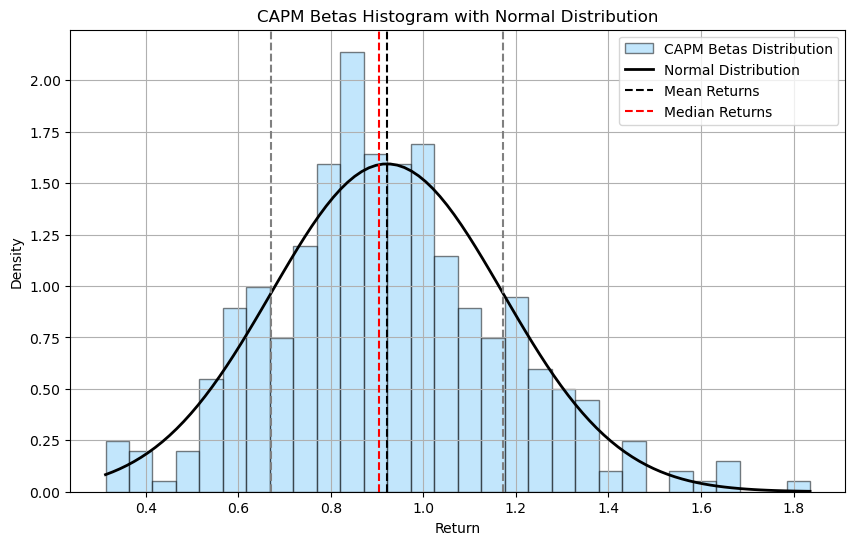

In [17]:
# Calculate Mean and Standard Deviation
mu = ff_betas_df['mkt_beta'].mean()
sigma = ff_betas_df['mkt_beta'].std()
median = ff_betas_df['mkt_beta'].median()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(ff_betas_df['mkt_beta'], bins=30, density=True, color='lightskyblue', alpha=0.5, edgecolor='black', label='CAPM Betas Distribution')

# Generate the Values of the Normal Distribution
x = np.linspace(ff_betas_df['mkt_beta'].min(), ff_betas_df['mkt_beta'].max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean Returns')
plt.axvline(x=median, color='red', linestyle='dashed', label='Median Returns')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('CAPM Betas Histogram with Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()

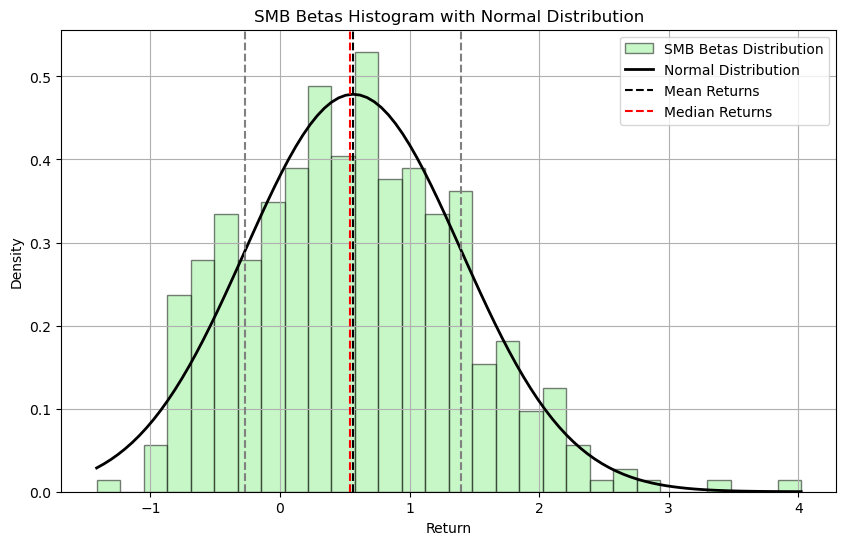

In [18]:
# Calculate Mean and Standard Deviation
mu = ff_betas_df['smb_beta'].mean()
sigma = ff_betas_df['smb_beta'].std()
median = ff_betas_df['smb_beta'].median()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(ff_betas_df['smb_beta'], bins=30, density=True, color='lightgreen', alpha=0.5, edgecolor='black', label='SMB Betas Distribution')

# Generate the Values of the Normal Distribution
x = np.linspace(ff_betas_df['smb_beta'].min(), ff_betas_df['smb_beta'].max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean Returns')
plt.axvline(x=median, color='red', linestyle='dashed', label='Median Returns')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('SMB Betas Histogram with Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()

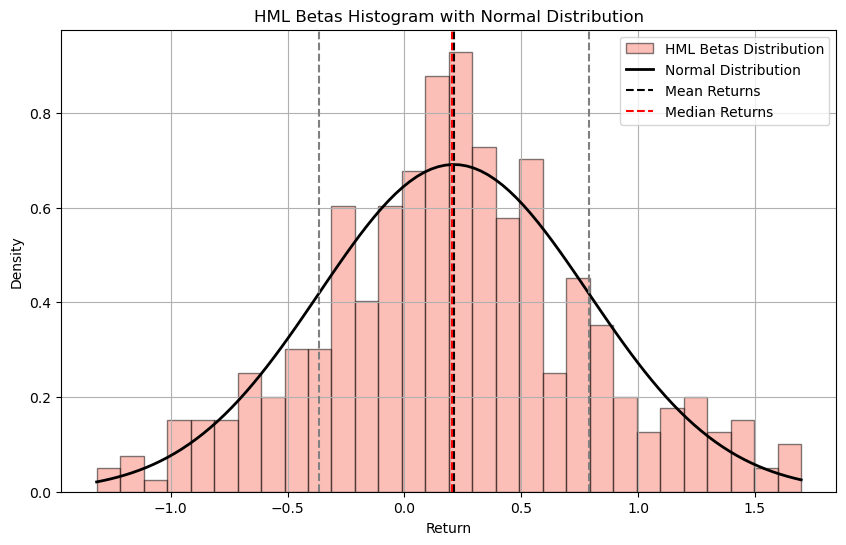

In [19]:
# Calculate Mean and Standard Deviation
mu = ff_betas_df['hml_beta'].mean()
sigma = ff_betas_df['hml_beta'].std()
median = ff_betas_df['hml_beta'].median()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(ff_betas_df['hml_beta'], bins=30, density=True, color='salmon', alpha=0.5, edgecolor='black', label='HML Betas Distribution')

# Generate the Values of the Normal Distribution
x = np.linspace(ff_betas_df['hml_beta'].min(), ff_betas_df['hml_beta'].max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean Returns')
plt.axvline(x=median, color='red', linestyle='dashed', label='Median Returns')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('HML Betas Histogram with Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()

In [21]:
# Calculate the VIF
# Concat
X = pd.concat([
    market_excess_returns,
    SMB,
    HML,
], axis=1, join='inner')


X.dropna(inplace = True)

X.columns = ['mkt', 'smb', 'hml']

X

,mkt,smb,hml
Date,,,
2015-01-05,-0.018334,0.000614,-0.007472
2015-01-06,-0.008948,-0.002716,-0.000653
2015-01-07,0.011576,0.000453,-0.003583
2015-01-08,0.017832,0.002447,-0.002477
2015-01-09,-0.008458,0.001843,-0.001128
...,...,...,...
2024-10-22,-0.000589,-0.005932,0.004081
2024-10-23,-0.009307,0.000967,0.005278
2024-10-24,0.002031,0.003483,-0.006245


In [23]:
vif_data = pd.DataFrame()
vif_data['vars'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,vars,VIF
0,mkt,1.063432
1,smb,1.189769
2,hml,1.122839


In [24]:
r_squared_df = pd.DataFrame()
r_squared_df['vars'] = X.columns

r_squared_df['r_squared'] = 1 - (1 / vif_data['VIF'])

r_squared_df

,vars,r_squared
0,mkt,0.059648
1,smb,0.159501
2,hml,0.109400


In [25]:
ff_betas_df.to_csv(r"..\additional_data\famafrench_betas.csv")